In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. Data Processing ##

In [2]:
%cd /content/drive/MyDrive/CV20231/BTL/Data

/content/drive/MyDrive/CV20231/BTL/Data


In [ ]:
"""Download data from kaggle"""
# ! pip install kaggle
# from google.colab import files
# files.upload()

# !rm -r ~/.kaggle
# ! mkdir ~/.kaggle
# ! cp kaggle.json ~/.kaggle/

# ! chmod 600 ~/.kaggle/kaggle.json

# ! kaggle competitions download severstal-steel-defect-detection

# from zipfile import ZipFile
# file_name="/content/drive/MyDrive/CV20231/BTL/Data/severstal-steel-defect-detection.zip"

# with ZipFile(file_name,'r') as zip:
#   zip.extractall()
#   print('Done')

'Download data from kaggle'

In [3]:
import pandas as pd
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib
from PIL import Image

import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn.functional as F
from tqdm import tqdm
from time import sleep

📌 Loading data

In [4]:
folder_path = '/content/drive/MyDrive/CV20231/BTL/Data/'
images_path = folder_path + 'train_images/'

tab = pd.read_csv(folder_path+'train.csv')
c = 4
tab = tab[tab['ClassId'] == c].copy()
tab = tab.reset_index().drop('index', axis = 1)
image_list = tab['ImageId'].unique()
tab


,ImageId,ClassId,EncodedPixels
0,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
1,0025bde0c.jpg,4,315139 8 315395 15 315651 16 315906 17 316162 ...
2,002af848d.jpg,4,290800 6 291055 13 291311 15 291566 18 291822 ...
3,0030401a5.jpg,4,186833 1 187089 3 187344 6 187600 7 187855 10 ...
4,008621629.jpg,4,215548 3 215798 9 216051 12 216306 13 216560 1...
...,...,...,...
796,fda1a539d.jpg,4,128621 3 128876 8 129131 11 129386 13 129641 1...
797,fdb7c0397.jpg,4,155020 6 155268 16 155516 27 155764 37 156012 ...
798,feec56162.jpg,4,99346 1 99602 1 99858 1 100113 2 100369 3 1006...
799,ff6bfada2.jpg,4,90877 2 91131 4 91385 6 91638 9 91892 12 92146...


📌 The following is a function that converts **'running pixels'** to a 256 x 1600 matrix (same as image size), that shows the location of defect in an image (0: non-defect pixel, 1: defect pixel). Description of the running pixels can be found [here](https://www.kaggle.com/competitions/severstal-steel-defect-detection/overview/evaluation).

Detail:  
+ pairs of values that contain a start position and a run length. E.g. '1 3' implies starting at pixel 1 and running a total of 3 pixels (1,2,3).
+ The pixels are numbered from top to bottom, then left to right: 1 is pixel (1,1), 2 is pixel (2,1), etc.

In [5]:
def pix_to_mat(pixels, h , w):
    p_list = pixels.split()
    start = np.array(p_list[0::2]).astype(int)
    length = np.array(p_list[1::2]).astype(int)
    n = len(start)
    m = np.zeros(h*w)
    for i in range(n):
        m[start[i] - 1 : start[i] - 1 + length[i]] = 1
    m = m.reshape(w,h).T
    return m

📌 There are a total of 801 images, which are split into 741, 30, 30 as train, validation, and test sets.

In [7]:
np.random.seed(39)
print(len(image_list))

n = 50 #val and test

test = image_list[:n]
val = image_list[n:2 * n]
train = image_list[2 * n:]
for l in train, val, test:
    print(len(l))

print(test[:2])

801
701
50
50
['000f6bf48.jpg' '0025bde0c.jpg']


📌**Crops**
As I mentioned before, each image is <ins>256 x 1600</ins>. What I am going to do is, for each of the train, validation, test set, I am going to take multiple crops within each image. **Each crop** will be of size **256 x 256**. Now, that means that the whole range of height will be cropped, but horizontally, the width will have a starting index, that stretches rightward by 256 pixels. Thus, if I took 450 as the index, then 450~705 would be the range of indices that would be cropped from the width dimension. You can see below that I have taken 33 crop locations from the train set, and 12 crop locations from each of the validation and test sets.

In [8]:
train_pos = []
valtest_pos = []

for i in range(0,32):
    train_pos.append(i * 40)

train_pos.append(1344)

for j in range(0,11):
    valtest_pos.append(j * 130)

valtest_pos.append(1344)

print(len(train_pos))
print(train_pos)
print(len(valtest_pos))

33
[0, 40, 80, 120, 160, 200, 240, 280, 320, 360, 400, 440, 480, 520, 560, 600, 640, 680, 720, 760, 800, 840, 880, 920, 960, 1000, 1040, 1080, 1120, 1160, 1200, 1240, 1344]
12


Now, I'm not going to take all of the crops of the images. I will specifically choose cropped images that contain more than 12000 (for train) or 5000 (for val and test) pixels that have defects. Thus we end up with train: 4661 crops, val: 102, and test: 121. I have stored the imageid with its 'cropping location(on the width axis)' as 'expanded lists'. These lists will be used as part of the dataloaders.

In [9]:
train_expanded = []
val_expanded = []
test_expanded = []

for imageid in train:
    pixels = tab[tab['ImageId'] == imageid]['EncodedPixels'].item()
    image_mask = pix_to_mat(pixels, 256, 1600)

    for p in train_pos:

        if image_mask[:,p:p+256].sum() > 12000:

            train_expanded.append(imageid + '_' + str(p))

for imageid in val:
    pixels = tab[tab['ImageId'] == imageid]['EncodedPixels'].item()
    image_mask = pix_to_mat(pixels, 256, 1600)

    for p in valtest_pos:

        if image_mask[:,p:p+256].sum() > 5000:

            val_expanded.append(imageid + '_' + str(p))

for imageid in test:
    pixels = tab[tab['ImageId'] == imageid]['EncodedPixels'].item()
    image_mask = pix_to_mat(pixels, 256, 1600)

    for p in valtest_pos:

        if image_mask[:,p:p+256].sum() > 5000:

            test_expanded.append(imageid + '_' + str(p))

print(len(train_expanded))
print(len(val_expanded))
print(len(test_expanded))
print(test_expanded)

4389
165
189
['000f6bf48.jpg_390', '000f6bf48.jpg_520', '000f6bf48.jpg_650', '000f6bf48.jpg_780', '000f6bf48.jpg_910', '0025bde0c.jpg_1170', '0025bde0c.jpg_1300', '0025bde0c.jpg_1344', '0030401a5.jpg_650', '0030401a5.jpg_780', '0030401a5.jpg_910', '0030401a5.jpg_1040', '0030401a5.jpg_1170', '008621629.jpg_780', '008621629.jpg_910', '008621629.jpg_1040', '008621629.jpg_1170', '008621629.jpg_1300', '008621629.jpg_1344', '012f26693.jpg_0', '012f26693.jpg_130', '016efe618.jpg_0', '016efe618.jpg_130', '016efe618.jpg_260', '016efe618.jpg_390', '016efe618.jpg_520', '016efe618.jpg_1170', '016efe618.jpg_1300', '016efe618.jpg_1344', '018ccdfed.jpg_650', '018ccdfed.jpg_780', '018ccdfed.jpg_1040', '018ccdfed.jpg_1170', '018ccdfed.jpg_1300', '018ccdfed.jpg_1344', '01cfacf80.jpg_0', '01cfacf80.jpg_130', '01cfacf80.jpg_260', '01cfacf80.jpg_390', '01cfacf80.jpg_520', '0218c0fcc.jpg_650', '0218c0fcc.jpg_780', '0218c0fcc.jpg_910', '02d573611.jpg_780', '02d573611.jpg_910', '02d573611.jpg_1040', '038f1445

I have used **dataset-wide** normalization of the images. The values have been pre-computed and copy-pasted below in the code as MEAN and STD. Firstly, the images in the dataset, though in 3 dimensions, are actually one-dimensional (gray-scale?). The R, G, B channels all have the same values. So firstly, you can reduce the image from a **3 x 256 x 256** to a **1 x 256 x 256** dimension. Each image then has a mean pixel value. This mean is calculated over the entire dataset (actually just the train), and then the mean of those means is computed, which is the 'MEAN' value below. Then, STD is calculated by calculating the following:

$$STD = \sqrt{\frac{1}{n_{t}} \sum_{i=1}^{n_{t}} \frac{1}{256 \times 256} \sum_{j=1}^{all pixels} (x_{j} - MEAN)^2}$$

where $n_{t}$ is the number of train images.

In the code, there is a transformation called 'ToTensor()' which scales the image from 0-255 to 0-1 scale, so we should keep that in mind when we compute. In addition to having more crops, for the training data, each image will randomly be vertically flipped, and then independently, randomly be horizontally flipped. The Custom Datasets and Dataloaders are created for train, val, and test.

In [10]:
MEAN =  99.45881939063021
STD =  50.285401061795476

t1 = transforms.ToTensor()
vf = transforms.RandomVerticalFlip()
hf = transforms.RandomHorizontalFlip()

class data(Dataset):

    def __init__(self, list_expanded, data_type):
                    #data_type: 'train', 'val', or 'test.

        self.list_expanded = list_expanded
        self.data_type = data_type

    def __len__(self):

        return len(self.list_expanded)

    def __getitem__(self, idx):

        imageid = self.list_expanded[idx].split('_')[0]
        p =  int(self.list_expanded[idx].split('_')[1])
        image = Image.open(images_path + imageid)

        m = MEAN/255
        s = STD/255

        t2 = transforms.Normalize(mean = m , std = s)

        img_tensor = t2(t1(image)[0].unsqueeze(0))

        X_ = img_tensor[:, :, p : p + 256]

        pixels = tab[tab['ImageId'] == imageid]['EncodedPixels'].item()
        image_mask = pix_to_mat(pixels, 256, 1600)
        y_ = torch.tensor(image_mask).unsqueeze(0)[:, :, p : p + 256]

        if self.data_type == 'train':

            if np.random.randint(1,3) == 1:
                X_ = vf(X_)
                y_ = vf(y_)

            if np.random.randint(1,3) == 1:
                X_ = hf(X_)
                y_ = hf(y_)

        return X_, y_

torch.manual_seed(6)

traindata = data(train_expanded, 'train')
valdata = data(val_expanded, 'val')
testdata = data(test_expanded, 'test')

trainloader = DataLoader(traindata, batch_size = 16, num_workers = 2, shuffle = True)
valloader = DataLoader(valdata, batch_size = len(val_expanded), num_workers = 2, shuffle = False)
testloader = DataLoader(testdata, batch_size = len(test_expanded), num_workers = 2, shuffle = False)

## 2. Model Building and Training ##

This is a modified version of the U-Net Architecture, where the features of channels for the convolutions are smaller, and the same paddings are applied. The skip connections will not be cropped.

In [11]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
print(device)

class DoubleConvs(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.ic = in_channels
        self.oc = out_channels
        self.conv1 = nn.Conv2d(self.ic, self.oc, kernel_size = 3, padding = 1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(self.oc, self.oc, kernel_size = 3, padding = 1)
        self.relu2 = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)

        return x

class UNet(nn.Module):

    def __init__(self):

        super().__init__()

        self.cs = [1,32,64,128,256,512]
        self.DownConvs = nn.ModuleList(DoubleConvs(self.cs[i],self.cs[i+1]) for i in range(4))
        self.DownPools = nn.ModuleList(nn.MaxPool2d(kernel_size = 2, stride = 2) for i in range(4))
        self.Bottleneck = DoubleConvs(256,512)
        self.UpConvs = nn.ModuleList(DoubleConvs(self.cs[i], self.cs[i-1]) for i in range(5,1,-1))
        self.Ups = nn.ModuleList(nn.ConvTranspose2d(self.cs[i], self.cs[i-1], kernel_size = 2, stride = 2) for i in range(5,1,-1))
        self.FinalConv = nn.Conv2d(32, 1, kernel_size = 3, padding = 1)
        self.Sigmoid = nn.Sigmoid()

    def forward(self, x):

        skip_connections = []

        for i in range(4):
            x = self.DownConvs[i](x)
            skip_connections.append(x)
            x = self.DownPools[i](x)

        x = self.Bottleneck(x)

        skip_connections.reverse()

        for i in range(4):
            x = self.Ups[i](x)
            x = torch.cat([x, skip_connections[i]], dim = 1)
            x = self.UpConvs[i](x)

        x = self.FinalConv(x)
        x = self.Sigmoid(x)

        return x

torch.manual_seed(5)
model = UNet().to(device)

cuda


# **3. Metrics**

In [12]:
import torch
import torch.nn as nn
import numpy as np

In [13]:
def iou_score_fn(output, target):
    smooth = 1e-5

    # if torch.is_tensor(output):
    #    output = torch.sigmoid(output).data.cpu().numpy()
    # if torch.is_tensor(target):
    #    target = target.data.cpu().numpy()

    output = output.data.cpu().numpy()
    target = target.data.cpu().numpy()

    output_ = output > 0.5
    target_ = target > 0.5
    intersection = (output_ & target_).sum()
    union = (output_ | target_).sum()

    return (intersection + smooth) / (union + smooth)

def dice_coef_fn(output, target):
    smooth = 1e-5

    output = output.view(-1)
    target = target.view(-1)
    intersection = (output * target).sum()

    return (2. * intersection + smooth) / (output.sum() + target.sum() + smooth)

class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)

        return 1 - dice

dice_loss = DiceLoss()
def calc_loss(pred, target, bce_weight=1):
    bce = F.binary_cross_entropy_with_logits(pred, target, reduction='mean')
    dice =  dice_loss(pred, target)
    loss = bce * bce_weight + dice * (bce_weight)
    return loss

# **4. Training & Prediction**

In [14]:
!pip install pytorch_lightning >> dev null

In [15]:
import os
import torch
import pytorch_lightning as pl

In [16]:
# Lightning module
class Segmentor(pl.LightningModule):
    def __init__(self, model = model):
        super().__init__()
        self.model = model
    def forward(self, x):
        return self.model(x)

    def get_metrics(self):
        # don't show the version number
        items = super().get_metrics()
        items.pop("v_num", None)
        return items

    def _step(self, batch):
        image, y_true = batch
        y_pred = self.model(image)
        loss = calc_loss(y_pred,y_true.float())
        dice_score = dice_coef_fn(y_pred, y_true)
        iou_score = iou_score_fn(y_pred, y_true)
        return loss, dice_score, iou_score

    def training_step(self, batch, batch_idx):
        loss, dice_score, iou_score = self._step(batch)
        metrics = {"loss": loss, "train_dice": dice_score, "train_iou": iou_score}
        self.log_dict(metrics, on_step=False, on_epoch=True, prog_bar = True)
        return loss

    def validation_step(self, batch, batch_idx):
        loss, dice_score, iou_score = self._step(batch)
        metrics = {"val_loss": loss, "val_dice": dice_score, "val_iou": iou_score}
        self.log_dict(metrics, prog_bar = True)
        return metrics

    def test_step(self, batch, batch_idx):
        loss, dice_score, iou_score = self._step(batch)
        metrics = {"loss":loss, "test_dice": dice_score, "test_iou": iou_score}
        self.log_dict(metrics, prog_bar = True)
        return metrics


    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.0001)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max",
                                                         factor = 0.5, patience=10, verbose =True)
        lr_schedulers = {"scheduler": scheduler, "monitor": "val_dice"}
        return [optimizer], lr_schedulers

In [17]:
# Training config
os.makedirs('/content/drive/MyDrive/CV20231/BTL/Weights', exist_ok = True)
check_point = pl.callbacks.model_checkpoint.ModelCheckpoint("/content/drive/MyDrive/CV20231/BTL/Weights", filename="ckpt{val_dice:0.4f}",
                                                            monitor="val_dice", mode = "max", save_top_k =1,
                                                            verbose=True, save_weights_only=True,
                                                            auto_insert_metric_name=False,)
progress_bar = pl.callbacks.TQDMProgressBar()
PARAMS = {"benchmark": True, "enable_progress_bar" : True,"logger":True,
          "callbacks" : [check_point, progress_bar],
          "log_every_n_steps" :1, "num_sanity_val_steps":0, "max_epochs":100,
          "precision":16,
          }
trainer = pl.Trainer(**PARAMS)
segmentor = Segmentor(model=model)

/usr/local/lib/python3.10/dist-packages/lightning_fabric/connector.py:558: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
# Training
trainer.fit(segmentor, trainloader, valloader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type | Params
-------------------------------
0 | model | UNet | 7.8 M 
-------------------------------
7.8 M     Trainable params
0         Non-trainable params
7.8 M     Total params
31.039    Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 275: 'val_dice' reached 0.65472 (best 0.65472), saving model to '/content/drive/MyDrive/CV20231/BTL/Weights/ckpt0.6547.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 550: 'val_dice' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 825: 'val_dice' reached 0.67827 (best 0.67827), saving model to '/content/drive/MyDrive/CV20231/BTL/Weights/ckpt0.6783.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 1100: 'val_dice' reached 0.67908 (best 0.67908), saving model to '/content/drive/MyDrive/CV20231/BTL/Weights/ckpt0.6791.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 1375: 'val_dice' reached 0.68670 (best 0.68670), saving model to '/content/drive/MyDrive/CV20231/BTL/Weights/ckpt0.6867.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 5, global step 1650: 'val_dice' reached 0.69456 (best 0.69456), saving model to '/content/drive/MyDrive/CV20231/BTL/Weights/ckpt0.6946.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 6, global step 1925: 'val_dice' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 7, global step 2200: 'val_dice' reached 0.70273 (best 0.70273), saving model to '/content/drive/MyDrive/CV20231/BTL/Weights/ckpt0.7027.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 8, global step 2475: 'val_dice' reached 0.71258 (best 0.71258), saving model to '/content/drive/MyDrive/CV20231/BTL/Weights/ckpt0.7126.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 9, global step 2750: 'val_dice' reached 0.71555 (best 0.71555), saving model to '/content/drive/MyDrive/CV20231/BTL/Weights/ckpt0.7156.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 10, global step 3025: 'val_dice' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 11, global step 3300: 'val_dice' reached 0.72432 (best 0.72432), saving model to '/content/drive/MyDrive/CV20231/BTL/Weights/ckpt0.7243.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 12, global step 3575: 'val_dice' reached 0.72674 (best 0.72674), saving model to '/content/drive/MyDrive/CV20231/BTL/Weights/ckpt0.7267.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 13, global step 3850: 'val_dice' reached 0.73916 (best 0.73916), saving model to '/content/drive/MyDrive/CV20231/BTL/Weights/ckpt0.7392.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 14, global step 4125: 'val_dice' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 15, global step 4400: 'val_dice' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 16, global step 4675: 'val_dice' reached 0.74225 (best 0.74225), saving model to '/content/drive/MyDrive/CV20231/BTL/Weights/ckpt0.7423.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 17, global step 4950: 'val_dice' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 18, global step 5225: 'val_dice' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 19, global step 5500: 'val_dice' reached 0.74455 (best 0.74455), saving model to '/content/drive/MyDrive/CV20231/BTL/Weights/ckpt0.7445.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 20, global step 5775: 'val_dice' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 21, global step 6050: 'val_dice' reached 0.74896 (best 0.74896), saving model to '/content/drive/MyDrive/CV20231/BTL/Weights/ckpt0.7490.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 22, global step 6325: 'val_dice' reached 0.74937 (best 0.74937), saving model to '/content/drive/MyDrive/CV20231/BTL/Weights/ckpt0.7494.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 23, global step 6600: 'val_dice' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 24, global step 6875: 'val_dice' reached 0.74985 (best 0.74985), saving model to '/content/drive/MyDrive/CV20231/BTL/Weights/ckpt0.7499.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 25, global step 7150: 'val_dice' reached 0.75161 (best 0.75161), saving model to '/content/drive/MyDrive/CV20231/BTL/Weights/ckpt0.7516.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 26, global step 7425: 'val_dice' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 27, global step 7700: 'val_dice' reached 0.75902 (best 0.75902), saving model to '/content/drive/MyDrive/CV20231/BTL/Weights/ckpt0.7590.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 28, global step 7975: 'val_dice' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 29, global step 8250: 'val_dice' reached 0.76007 (best 0.76007), saving model to '/content/drive/MyDrive/CV20231/BTL/Weights/ckpt0.7601.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 30, global step 8525: 'val_dice' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 31, global step 8800: 'val_dice' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 32, global step 9075: 'val_dice' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 33, global step 9350: 'val_dice' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 34, global step 9625: 'val_dice' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 35, global step 9900: 'val_dice' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 36, global step 10175: 'val_dice' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 37, global step 10450: 'val_dice' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 38, global step 10725: 'val_dice' reached 0.76515 (best 0.76515), saving model to '/content/drive/MyDrive/CV20231/BTL/Weights/ckpt0.7651.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 39, global step 11000: 'val_dice' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 40, global step 11275: 'val_dice' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 41, global step 11550: 'val_dice' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 42, global step 11825: 'val_dice' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 43, global step 12100: 'val_dice' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 44, global step 12375: 'val_dice' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 45, global step 12650: 'val_dice' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 46, global step 12925: 'val_dice' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 47, global step 13200: 'val_dice' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 48, global step 13475: 'val_dice' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 49, global step 13750: 'val_dice' was not in top 1


Epoch 00050: reducing learning rate of group 0 to 5.0000e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 50, global step 14025: 'val_dice' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 51, global step 14300: 'val_dice' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 52, global step 14575: 'val_dice' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 53, global step 14850: 'val_dice' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 54, global step 15125: 'val_dice' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 55, global step 15400: 'val_dice' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 56, global step 15675: 'val_dice' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 57, global step 15950: 'val_dice' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 58, global step 16225: 'val_dice' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 59, global step 16500: 'val_dice' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 60, global step 16775: 'val_dice' was not in top 1


Epoch 00061: reducing learning rate of group 0 to 2.5000e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 61, global step 17050: 'val_dice' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 62, global step 17325: 'val_dice' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 63, global step 17600: 'val_dice' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 64, global step 17875: 'val_dice' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 65, global step 18150: 'val_dice' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 66, global step 18425: 'val_dice' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 67, global step 18700: 'val_dice' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 68, global step 18975: 'val_dice' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 69, global step 19250: 'val_dice' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 70, global step 19525: 'val_dice' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 71, global step 19800: 'val_dice' was not in top 1


Epoch 00072: reducing learning rate of group 0 to 1.2500e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 72, global step 20075: 'val_dice' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 73, global step 20350: 'val_dice' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 74, global step 20625: 'val_dice' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 75, global step 20900: 'val_dice' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 76, global step 21175: 'val_dice' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 77, global step 21450: 'val_dice' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 78, global step 21725: 'val_dice' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 79, global step 22000: 'val_dice' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 80, global step 22275: 'val_dice' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 81, global step 22550: 'val_dice' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 82, global step 22825: 'val_dice' was not in top 1


Epoch 00083: reducing learning rate of group 0 to 6.2500e-06.


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 83, global step 23100: 'val_dice' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 84, global step 23375: 'val_dice' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 85, global step 23650: 'val_dice' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 86, global step 23925: 'val_dice' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 87, global step 24200: 'val_dice' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 88, global step 24475: 'val_dice' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 89, global step 24750: 'val_dice' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 90, global step 25025: 'val_dice' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 91, global step 25300: 'val_dice' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 92, global step 25575: 'val_dice' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 93, global step 25850: 'val_dice' was not in top 1


Epoch 00094: reducing learning rate of group 0 to 3.1250e-06.


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 94, global step 26125: 'val_dice' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 95, global step 26400: 'val_dice' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 96, global step 26675: 'val_dice' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 97, global step 26950: 'val_dice' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 98, global step 27225: 'val_dice' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 99, global step 27500: 'val_dice' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


In [18]:
import torch
import pytorch_lightning as pl
import matplotlib.pyplot as plt

In [19]:
# Lightning module
class Segmentor(pl.LightningModule):
    def __init__(self, model=model):
        super().__init__()
        self.model = model

    def forward(self, x):
        return self.model(x)

    def test_step(self, batch, batch_idx):
        image, y_true = batch
        y_pred = self.model(image)
        # dice = dice_score(y_pred, y_true)
        # iou = iou_score(y_pred, y_true)
        dice = dice_coef_fn(y_pred, y_true)
        iou = iou_score_fn(y_pred, y_true)
        metrics = {"Test Dice": dice, "Test Iou": iou}
        self.log_dict(metrics, prog_bar=True)
        return metrics

In [20]:
# For visualization
def visualize_prediction(model, dataset, nums):
    plt.figure(figsize=(6, 2*nums), layout='compressed')
    for idx in range(nums):
        x, y = dataset[idx]
        y_pred = model(x.unsqueeze(dim=0)).data.squeeze()
        y_pred[y_pred>0.5] = 1
        y_pred[y_pred<=0.5] = 0

        # convert torch to numpy
        x = x.permute(1, 2, 0).numpy()
        y = y.squeeze().numpy()
        y_pred = y_pred.numpy()

        # visualization
        plt.subplot(nums, 3, 3*idx + 1)
        plt.title(f"Image {idx+1}")
        plt.imshow(x, cmap='gray')
        plt.axis('off')

        plt.subplot(nums, 3, 3*idx + 2)
        plt.title(f"Ground truth {idx+1}")
        plt.imshow(y, cmap='gray')
        plt.axis('off')

        plt.subplot(nums, 3, 3*idx + 3)
        plt.title(f"U-Net {idx+1}")
        plt.imshow(y_pred, cmap='gray')
        plt.axis('off')

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         Test Dice         │    0.7738059533728386     │
│         Test Iou          │    0.6313968300819397     │
└───────────────────────────┴───────────────────────────┘

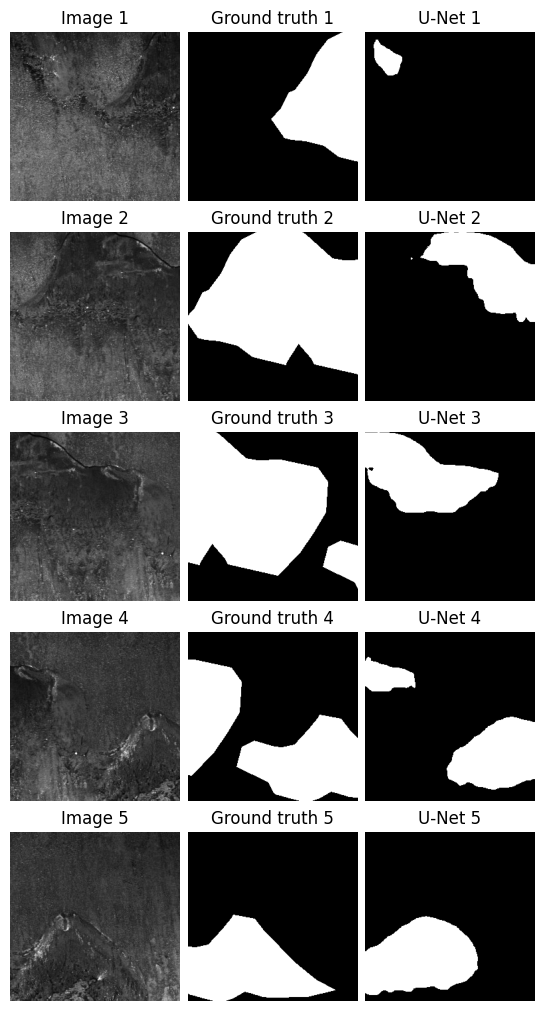

In [21]:
model = UNet().to(device)
# Dataset & Data Loader
CHECKPOINT_PATH = "/content/drive/MyDrive/CV20231/BTL/Weights/ckpt0.7651.ckpt"
# Prediction
trainer = pl.Trainer()
# segmentor = Segmentor(model=model)
# segmentor = segmentor.load_from_checkpoint(CHECKPOINT_PATH)
segmentor = Segmentor.load_from_checkpoint(CHECKPOINT_PATH, model = model)
trainer.test(segmentor, testloader)

# Visualization
visualize_prediction(model=model, dataset=testdata, nums=5)